In [ ]:

from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import numpy as np
import rasterio


In [ ]:

# Set your Copernicus Open Access Hub credentials
API_USERNAME = ''
API_PASSWORD = ''

# Initialize the SentinelAPI with your credentials
api = SentinelAPI(API_USERNAME, API_PASSWORD, 'https://scihub.copernicus.eu/dhus')

# Define the Area of Interest (AOI) in GeoJSON format or a shapefile
AOI_PATH = r'C:\Users\sonika.dixit\Downloads\india_district\Vishakhapatnam.shp'

# Read the data and convert it to WKT format
### we can take AOI_Path directly but converting into WKT format queries more accurately
aoi_gdf = gpd.read_file(AOI_PATH)
aoi_geojson = aoi_gdf.to_crs(epsg=4326).geometry.to_json()
footprint = aoi_gdf.geometry.iloc[0]

# Define other query parameters (adjust as needed)
start_date = '20220421'
end_date = '20220630'
cloud_cover = (0, 30)  # Specify the desired cloud cover percentage range

# Query the Copernicus Open Access Hub for Sentinel-2 products
products = api.query(footprint,
                     date=(start_date,end_date),
                     platformname='Sentinel-2',
                     cloudcoverpercentage=cloud_cover)

# Download the first product (you can customize this)
if products:
    product_id = list(products.keys())[0]
    api.download(product_id, directory_path= r'C:\Users\sonika.dixit\Downloads\output')
    print(f"Downloaded Sentinel-2 product {product_id}")
else:
    print("No Sentinel-2 products found for the given criteria.")

In [1]:


# Define input and output paths
input_folder = r'C:\Users\sonika.dixit\Downloads\SentData'
output_folder = r'C:\Users\sonika.dixit\Downloads\output'

# List all the downloaded Sentinel-2 images in the input folder
image_files = [file for file in os.listdir(input_folder) if file.endswith('.tif')]

# Loop through each image and calculate NDVI
for image_file in image_files:
    input_path = os.path.join(input_folder, image_file)
    output_path = os.path.join(output_folder, f'ndvi_{image_file}')
    
    # Open the input image using rasterio
    with rasterio.open(input_path) as src:
        red_band = src.read(3)  # Red band (B04)
        nir_band = src.read(8)  # Near-Infrared band (B08)

        # Preprocess bands (e.g., cloud masking)
        cloud_mask = np.logical_or(red_band > 10000, nir_band > 10000)  # Example cloud masking
        red_band[cloud_mask] = 0
        nir_band[cloud_mask] = 0

        # Do not display error when divided by zero 
        np.seterr(divide='ignore', invalid='ignore')

        # Calculate NDVI 
        ndvi = (nir_band.astype(float) - red_band.astype(float)) / (nir_band + red_band)
        
        #print the max and min of ndvi
        print(np.nanmin(ndvi)) 
        print(np.nanmax(ndvi))
        
        # Apply a basic threshold to identify vegetation/non-vegetation
        vegetation_mask = ndvi > 0.2  # Example threshold
        ndvi[~vegetation_mask] = 0

        # Prepare the metadata for the output NDVI image
        meta = src.meta.copy()
        meta.update(count=1, dtype=rasterio.float32)
        # Write the NDVI image to the output folder
        with rasterio.open(output_path, 'w', **meta) as dst:
            dst.write(ndvi.astype(rasterio.float32), 1)

    print(f'NDVI image generated for {image_file}')

print('NDVI processing complete.')





-1.0
0.9936102236421726
NDVI image generated for sentinel2_cast-0000000000-0000009728.tif
NDVI processing complete.


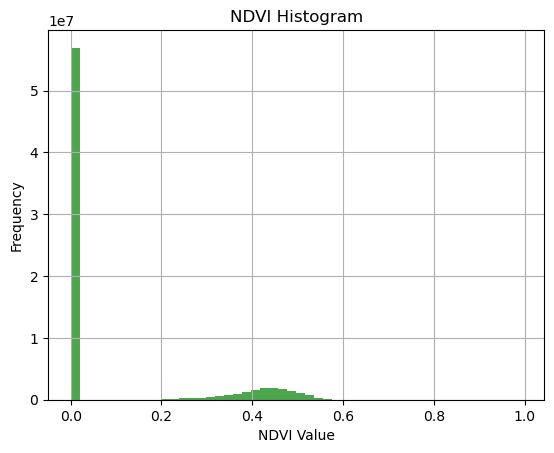

In [2]:


# Flatten the NDVI array
ndvi_flat = ndvi.flatten()

# Plot histogram
plt.hist(ndvi_flat, bins=50, color='green', alpha=0.7)
plt.xlabel('NDVI Value')
plt.ylabel('Frequency')
plt.title('NDVI Histogram')
plt.grid(True)
plt.show()


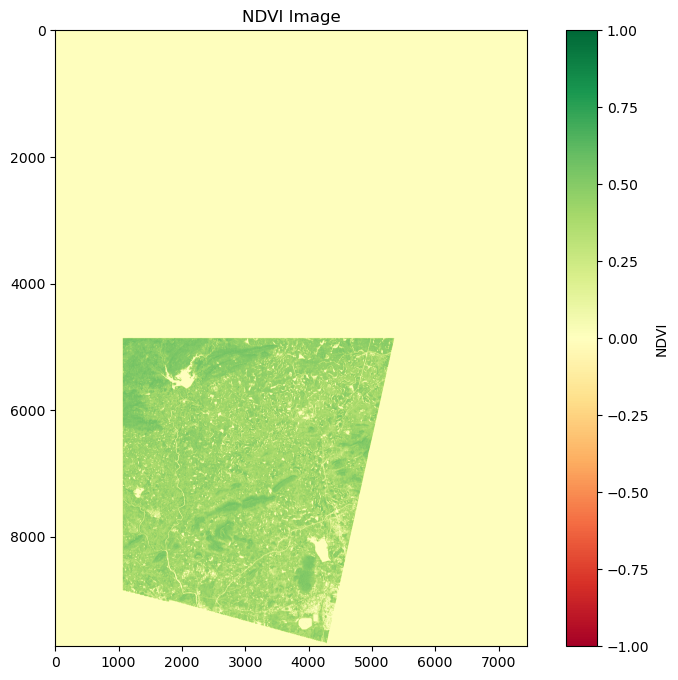

In [3]:
# Plot NDVI image
plt.figure(figsize=(10, 8))
plt.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)  # Adjust vmin and vmax as needed
plt.colorbar(label='NDVI')
plt.title('NDVI Image')
plt.show()
